In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.metrics import  precision_score, recall_score, f1_score,balanced_accuracy_score
import seaborn as sns
from tqdm import tqdm
from utils.Preprocessing_utils import output_selection_prepro
from utils.heatmap_plots import plot_heat_map, plot_metrics
from predict_model import test_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from models.FeedForwardNet.model import Net as Net
from models.FeedForwardNet.model_3 import Net as Net3
from torchvision import models

In [2]:
df = pd.read_csv('data/raw/dukecathr.csv')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:

train_losses=[]
train_accu=[]
eval_losses=[]
eval_accu=[]
balance_accuracy_list = []
precision_list = []
recall_list = []

In [4]:
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for data in tqdm(dataloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        pred = model(inputs)
        predicted = torch.round(pred)  # Round the output probabilities to get binary predictions
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss=running_loss/len(dataloader)
    accu=100.*correct/total
    return train_loss, accu

In [5]:
def evaluate_epoch(model, dataloader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    for data in dataloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        predicted = torch.round(outputs)  # Round the output probabilities to get binary predictions
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Store all labels and predictions for metric calculation
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.detach().cpu().numpy())  # Detach the tensor before converting to numpy
            
    test_loss=running_loss/len(dataloader)
    test_accu=100.*correct/total

    # Calculate metrics
    balance_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    return test_loss, test_accu, balance_acc, precision, recall

In [6]:
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=25, model_path='models/FeedForwardNet/saved_model.pth'):
    model = model.to(device)  # Move the model to the GPU
    
    for epoch in range(num_epochs):
        print(f'Epoch : {epoch+1}')
        
        train_loss, accu = train_epoch(model, train_dataloader, criterion, optimizer)
        train_accu.append(accu)
        train_losses.append(train_loss)

        test_loss, test_accu, balance_acc, precision, recall = evaluate_epoch(model, test_dataloader, criterion)
        eval_losses.append(test_loss)
        eval_accu.append(test_accu)

        # Append the metrics to the lists
        balance_accuracy_list.append(balance_acc)
        precision_list.append(precision)
        recall_list.append(recall)

        print(f'Train Loss: {train_loss:.3f} | Train Accuracy: {accu:.3f} | Test Loss: {test_loss:.3f} | Test Accuracy: {test_accu:.3f} | Balance Accuracy: {balance_acc:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f}')

    # Compute the average of the metrics over all epochs
    avg_balance_acc = sum(balance_accuracy_list) / len(balance_accuracy_list)
    avg_precision = sum(precision_list) / len(precision_list)
    avg_recall = sum(recall_list) / len(recall_list)
    torch.save(model.state_dict(), model_path)
     
     

    # Store the averages in a list
    averages = [avg_balance_acc, avg_precision, avg_recall]

    return averages

In [7]:
def evaluate_model(model, dataloader, criterion):
    model = model.to(device)  # Move the model to the GPU
    model.eval()  # Set model to evaluate mode
    running_loss=0
    correct=0
    total=0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for data in tqdm(dataloader):
            images,labels=data[0].to(device),data[1].to(device)
            outputs=model(images)
            loss= criterion(outputs,labels)
            running_loss+=loss.item()
            predicted = torch.round(outputs)  # Round the output probabilities to get binary predictions
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Store all labels and predictions for metric calculation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            
    test_loss=running_loss/len(dataloader)
    accu=100.*correct/total
    eval_losses.append(test_loss)
    eval_accu.append(accu)
    
    # Calculate metrics
    balance_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    # Append the metrics to the lists
    balance_accuracy_list.append(balance_acc)
    precision_list.append(precision)
    recall_list.append(recall)

    print(f'Test Loss: {test_loss:.3f} | Accuracy: {accu:.3f}')

In [8]:
def process_target(df, target, model):
   # Step 1: Preprocess the data
   X, y, num_cols, cat_cols = output_selection_prepro(df, target)

   # Split the data into train and test sets
   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=465)
   
   Scaler = StandardScaler( )
   X_train = Scaler.fit_transform(X_train)
   X_test = Scaler.transform(X_test)
   
   
   # Convert features and labels to tensors
   X_train_tensor = torch.tensor(X_train.astype(np.float32))
   X_test_tensor = torch.tensor(X_test.astype(np.float32))
   y_train_tensor = torch.tensor(y_train.values).float().unsqueeze(1)
   y_test_tensor = torch.tensor(y_test.values).float().unsqueeze(1)

   # Convert the data into PyTorch tensors and load them into a DataLoader
   train_data = TensorDataset(X_train_tensor, y_train_tensor)
   test_data = TensorDataset(X_test_tensor, y_test_tensor)
   #save test data
   torch.save(test_data, f'data/processed/{target}/test_data.pth')

   batch_size = 2048
   train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
   test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

   # Define the model, loss function, and optimizer
   model = model
   criterion = nn.BCELoss()
   optimizer = torch.optim.Adam(model.parameters(), lr=0.00009)

   # Train the model
   average = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=200)
   
   
   print(f'\nAverage Balanced Accuracy: {average[0]:.3f} | Average Precision: {average[1]:.3f} | Average Recall: {average[2]:.3f}')
   evaluate_model(model, test_loader, criterion)

In [9]:
process_target(df, 'RCAST', Net3(43))

Loading data from data/processed/RCAST/imputed_data_RCAST.csv...
No missing values found.
Final X columns: ['RDAYSFROMINDEX', 'RSEQCATHNUM', 'RSUBJID', 'YRCATH_G', 'AGE_G', 'GENDER', 'RACE_G', 'DPCABG', 'DPMI', 'DPPCI', 'HXANGINA', 'HXCEREB', 'HXCHF', 'HXCOPD', 'HXDIAB', 'HXHTN', 'HXHYL', 'HXMI', 'HXSMOKE', 'NUMPRMI', 'DIASBP_R', 'PULSE_R', 'SYSBP_R', 'CBRUITS', 'HEIGHT_R', 'S3', 'WEIGHT_R', 'CREATININE_R', 'HDL_R', 'LDL_R', 'TOTCHOL_R', 'CATHAPPR', 'DIAGCATH', 'INTVCATH', 'CORDOM', 'GRAFTST', 'LVEF_R', 'DAYS2LKA', 'DSCABG', 'DSMI', 'DSPCI', 'DSSTROKE', 'FUPROTCL']
Epoch : 1


100%|██████████| 25/25 [00:01<00:00, 22.78it/s]


Train Loss: 0.649 | Train Accuracy: 63.367 | Test Loss: 0.625 | Test Accuracy: 69.397 | Balance Accuracy: 0.611 | Precision: 0.681 | Recall: 0.955
Epoch : 2


100%|██████████| 25/25 [00:00<00:00, 32.21it/s]


Train Loss: 0.603 | Train Accuracy: 68.392 | Test Loss: 0.569 | Test Accuracy: 71.087 | Balance Accuracy: 0.650 | Precision: 0.711 | Recall: 0.901
Epoch : 3


100%|██████████| 25/25 [00:00<00:00, 38.46it/s]


Train Loss: 0.574 | Train Accuracy: 70.141 | Test Loss: 0.551 | Test Accuracy: 71.976 | Balance Accuracy: 0.657 | Precision: 0.713 | Recall: 0.918
Epoch : 4


100%|██████████| 25/25 [00:00<00:00, 37.47it/s]


Train Loss: 0.562 | Train Accuracy: 70.569 | Test Loss: 0.539 | Test Accuracy: 72.263 | Balance Accuracy: 0.661 | Precision: 0.717 | Recall: 0.915
Epoch : 5


100%|██████████| 25/25 [00:00<00:00, 37.14it/s]


Train Loss: 0.553 | Train Accuracy: 71.311 | Test Loss: 0.533 | Test Accuracy: 72.442 | Balance Accuracy: 0.664 | Precision: 0.718 | Recall: 0.915
Epoch : 6


100%|██████████| 25/25 [00:00<00:00, 36.20it/s]


Train Loss: 0.545 | Train Accuracy: 71.648 | Test Loss: 0.530 | Test Accuracy: 72.657 | Balance Accuracy: 0.666 | Precision: 0.720 | Recall: 0.917
Epoch : 7


100%|██████████| 25/25 [00:00<00:00, 38.83it/s]


Train Loss: 0.542 | Train Accuracy: 71.974 | Test Loss: 0.523 | Test Accuracy: 72.818 | Balance Accuracy: 0.669 | Precision: 0.722 | Recall: 0.914
Epoch : 8


100%|██████████| 25/25 [00:00<00:00, 39.31it/s]


Train Loss: 0.538 | Train Accuracy: 72.094 | Test Loss: 0.521 | Test Accuracy: 73.027 | Balance Accuracy: 0.671 | Precision: 0.724 | Recall: 0.915
Epoch : 9


100%|██████████| 25/25 [00:00<00:00, 33.36it/s]


Train Loss: 0.534 | Train Accuracy: 72.591 | Test Loss: 0.520 | Test Accuracy: 73.212 | Balance Accuracy: 0.674 | Precision: 0.725 | Recall: 0.915
Epoch : 10


100%|██████████| 25/25 [00:00<00:00, 39.30it/s]


Train Loss: 0.531 | Train Accuracy: 72.549 | Test Loss: 0.517 | Test Accuracy: 73.433 | Balance Accuracy: 0.680 | Precision: 0.731 | Recall: 0.906
Epoch : 11


100%|██████████| 25/25 [00:00<00:00, 38.02it/s]


Train Loss: 0.530 | Train Accuracy: 72.836 | Test Loss: 0.517 | Test Accuracy: 73.648 | Balance Accuracy: 0.682 | Precision: 0.733 | Recall: 0.906
Epoch : 12


100%|██████████| 25/25 [00:00<00:00, 34.86it/s]


Train Loss: 0.526 | Train Accuracy: 73.031 | Test Loss: 0.515 | Test Accuracy: 73.761 | Balance Accuracy: 0.683 | Precision: 0.733 | Recall: 0.909
Epoch : 13


100%|██████████| 25/25 [00:00<00:00, 36.78it/s]


Train Loss: 0.525 | Train Accuracy: 73.166 | Test Loss: 0.514 | Test Accuracy: 73.785 | Balance Accuracy: 0.685 | Precision: 0.735 | Recall: 0.904
Epoch : 14


100%|██████████| 25/25 [00:00<00:00, 37.06it/s]


Train Loss: 0.523 | Train Accuracy: 73.335 | Test Loss: 0.512 | Test Accuracy: 73.994 | Balance Accuracy: 0.687 | Precision: 0.736 | Recall: 0.905
Epoch : 15


100%|██████████| 25/25 [00:00<00:00, 32.49it/s]


Train Loss: 0.521 | Train Accuracy: 73.397 | Test Loss: 0.512 | Test Accuracy: 73.976 | Balance Accuracy: 0.687 | Precision: 0.736 | Recall: 0.906
Epoch : 16


100%|██████████| 25/25 [00:00<00:00, 38.08it/s]


Train Loss: 0.519 | Train Accuracy: 73.546 | Test Loss: 0.506 | Test Accuracy: 74.131 | Balance Accuracy: 0.692 | Precision: 0.741 | Recall: 0.897
Epoch : 17


100%|██████████| 25/25 [00:00<00:00, 32.45it/s]


Train Loss: 0.518 | Train Accuracy: 73.678 | Test Loss: 0.508 | Test Accuracy: 74.310 | Balance Accuracy: 0.691 | Precision: 0.739 | Recall: 0.905
Epoch : 18


100%|██████████| 25/25 [00:01<00:00, 17.10it/s]


Train Loss: 0.515 | Train Accuracy: 73.700 | Test Loss: 0.507 | Test Accuracy: 74.507 | Balance Accuracy: 0.694 | Precision: 0.741 | Recall: 0.907
Epoch : 19


100%|██████████| 25/25 [00:00<00:00, 33.61it/s]


Train Loss: 0.514 | Train Accuracy: 73.801 | Test Loss: 0.501 | Test Accuracy: 74.472 | Balance Accuracy: 0.695 | Precision: 0.743 | Recall: 0.900
Epoch : 20


100%|██████████| 25/25 [00:00<00:00, 26.29it/s]


Train Loss: 0.514 | Train Accuracy: 73.918 | Test Loss: 0.503 | Test Accuracy: 74.597 | Balance Accuracy: 0.696 | Precision: 0.743 | Recall: 0.903
Epoch : 21


100%|██████████| 25/25 [00:00<00:00, 36.74it/s]


Train Loss: 0.513 | Train Accuracy: 74.028 | Test Loss: 0.506 | Test Accuracy: 74.621 | Balance Accuracy: 0.696 | Precision: 0.743 | Recall: 0.904
Epoch : 22


100%|██████████| 25/25 [00:00<00:00, 39.09it/s]


Train Loss: 0.511 | Train Accuracy: 74.056 | Test Loss: 0.503 | Test Accuracy: 74.627 | Balance Accuracy: 0.699 | Precision: 0.746 | Recall: 0.896
Epoch : 23


100%|██████████| 25/25 [00:00<00:00, 36.34it/s]


Train Loss: 0.511 | Train Accuracy: 74.217 | Test Loss: 0.501 | Test Accuracy: 74.710 | Balance Accuracy: 0.698 | Precision: 0.746 | Recall: 0.900
Epoch : 24


100%|██████████| 25/25 [00:00<00:00, 35.78it/s]


Train Loss: 0.508 | Train Accuracy: 74.342 | Test Loss: 0.498 | Test Accuracy: 74.746 | Balance Accuracy: 0.700 | Precision: 0.747 | Recall: 0.896
Epoch : 25


100%|██████████| 25/25 [00:00<00:00, 34.16it/s]


Train Loss: 0.509 | Train Accuracy: 74.326 | Test Loss: 0.499 | Test Accuracy: 74.812 | Balance Accuracy: 0.701 | Precision: 0.748 | Recall: 0.897
Epoch : 26


100%|██████████| 25/25 [00:00<00:00, 33.97it/s]


Train Loss: 0.507 | Train Accuracy: 74.488 | Test Loss: 0.500 | Test Accuracy: 74.896 | Balance Accuracy: 0.701 | Precision: 0.748 | Recall: 0.899
Epoch : 27


100%|██████████| 25/25 [00:00<00:00, 34.43it/s]


Train Loss: 0.507 | Train Accuracy: 74.368 | Test Loss: 0.502 | Test Accuracy: 74.973 | Balance Accuracy: 0.704 | Precision: 0.751 | Recall: 0.894
Epoch : 28


100%|██████████| 25/25 [00:00<00:00, 30.09it/s]


Train Loss: 0.506 | Train Accuracy: 74.559 | Test Loss: 0.502 | Test Accuracy: 75.027 | Balance Accuracy: 0.702 | Precision: 0.748 | Recall: 0.901
Epoch : 29


100%|██████████| 25/25 [00:00<00:00, 33.85it/s]


Train Loss: 0.506 | Train Accuracy: 74.603 | Test Loss: 0.497 | Test Accuracy: 75.039 | Balance Accuracy: 0.707 | Precision: 0.754 | Recall: 0.888
Epoch : 30


100%|██████████| 25/25 [00:00<00:00, 36.58it/s]


Train Loss: 0.503 | Train Accuracy: 74.683 | Test Loss: 0.501 | Test Accuracy: 74.931 | Balance Accuracy: 0.703 | Precision: 0.749 | Recall: 0.896
Epoch : 31


100%|██████████| 25/25 [00:00<00:00, 36.28it/s]


Train Loss: 0.503 | Train Accuracy: 74.788 | Test Loss: 0.496 | Test Accuracy: 75.158 | Balance Accuracy: 0.708 | Precision: 0.754 | Recall: 0.890
Epoch : 32


100%|██████████| 25/25 [00:00<00:00, 36.11it/s]


Train Loss: 0.503 | Train Accuracy: 74.712 | Test Loss: 0.498 | Test Accuracy: 75.104 | Balance Accuracy: 0.706 | Precision: 0.753 | Recall: 0.892
Epoch : 33


100%|██████████| 25/25 [00:00<00:00, 35.03it/s]


Train Loss: 0.501 | Train Accuracy: 74.854 | Test Loss: 0.500 | Test Accuracy: 75.140 | Balance Accuracy: 0.707 | Precision: 0.753 | Recall: 0.891
Epoch : 34


100%|██████████| 25/25 [00:00<00:00, 34.80it/s]


Train Loss: 0.500 | Train Accuracy: 74.886 | Test Loss: 0.498 | Test Accuracy: 75.152 | Balance Accuracy: 0.705 | Precision: 0.751 | Recall: 0.896
Epoch : 35


100%|██████████| 25/25 [00:00<00:00, 35.80it/s]


Train Loss: 0.500 | Train Accuracy: 74.907 | Test Loss: 0.495 | Test Accuracy: 75.152 | Balance Accuracy: 0.708 | Precision: 0.755 | Recall: 0.888
Epoch : 36


100%|██████████| 25/25 [00:00<00:00, 34.15it/s]


Train Loss: 0.500 | Train Accuracy: 74.913 | Test Loss: 0.496 | Test Accuracy: 75.164 | Balance Accuracy: 0.709 | Precision: 0.756 | Recall: 0.886
Epoch : 37


100%|██████████| 25/25 [00:00<00:00, 36.62it/s]


Train Loss: 0.499 | Train Accuracy: 74.945 | Test Loss: 0.495 | Test Accuracy: 75.290 | Balance Accuracy: 0.708 | Precision: 0.754 | Recall: 0.893
Epoch : 38


100%|██████████| 25/25 [00:00<00:00, 35.61it/s]


Train Loss: 0.498 | Train Accuracy: 75.100 | Test Loss: 0.494 | Test Accuracy: 75.164 | Balance Accuracy: 0.705 | Precision: 0.751 | Recall: 0.897
Epoch : 39


100%|██████████| 25/25 [00:00<00:00, 36.48it/s]


Train Loss: 0.498 | Train Accuracy: 74.969 | Test Loss: 0.494 | Test Accuracy: 75.194 | Balance Accuracy: 0.708 | Precision: 0.755 | Recall: 0.889
Epoch : 40


100%|██████████| 25/25 [00:00<00:00, 36.56it/s]


Train Loss: 0.495 | Train Accuracy: 75.142 | Test Loss: 0.498 | Test Accuracy: 75.170 | Balance Accuracy: 0.708 | Precision: 0.755 | Recall: 0.889
Epoch : 41


100%|██████████| 25/25 [00:00<00:00, 37.19it/s]


Train Loss: 0.496 | Train Accuracy: 75.077 | Test Loss: 0.489 | Test Accuracy: 75.278 | Balance Accuracy: 0.710 | Precision: 0.757 | Recall: 0.887
Epoch : 42


100%|██████████| 25/25 [00:00<00:00, 36.79it/s]


Train Loss: 0.495 | Train Accuracy: 75.176 | Test Loss: 0.494 | Test Accuracy: 75.218 | Balance Accuracy: 0.710 | Precision: 0.757 | Recall: 0.885
Epoch : 43


100%|██████████| 25/25 [00:00<00:00, 37.47it/s]


Train Loss: 0.495 | Train Accuracy: 75.258 | Test Loss: 0.494 | Test Accuracy: 75.242 | Balance Accuracy: 0.710 | Precision: 0.757 | Recall: 0.886
Epoch : 44


100%|██████████| 25/25 [00:00<00:00, 35.26it/s]


Train Loss: 0.495 | Train Accuracy: 75.216 | Test Loss: 0.493 | Test Accuracy: 75.403 | Balance Accuracy: 0.712 | Precision: 0.758 | Recall: 0.887
Epoch : 45


100%|██████████| 25/25 [00:00<00:00, 38.20it/s]


Train Loss: 0.494 | Train Accuracy: 75.254 | Test Loss: 0.496 | Test Accuracy: 75.325 | Balance Accuracy: 0.710 | Precision: 0.757 | Recall: 0.888
Epoch : 46


100%|██████████| 25/25 [00:00<00:00, 36.14it/s]


Train Loss: 0.494 | Train Accuracy: 75.441 | Test Loss: 0.493 | Test Accuracy: 75.385 | Balance Accuracy: 0.709 | Precision: 0.755 | Recall: 0.893
Epoch : 47


100%|██████████| 25/25 [00:00<00:00, 35.42it/s]


Train Loss: 0.493 | Train Accuracy: 75.242 | Test Loss: 0.494 | Test Accuracy: 75.403 | Balance Accuracy: 0.713 | Precision: 0.759 | Recall: 0.884
Epoch : 48


100%|██████████| 25/25 [00:00<00:00, 36.41it/s]


Train Loss: 0.491 | Train Accuracy: 75.554 | Test Loss: 0.494 | Test Accuracy: 75.510 | Balance Accuracy: 0.712 | Precision: 0.758 | Recall: 0.890
Epoch : 49


100%|██████████| 25/25 [00:00<00:00, 36.52it/s]


Train Loss: 0.492 | Train Accuracy: 75.301 | Test Loss: 0.487 | Test Accuracy: 75.713 | Balance Accuracy: 0.714 | Precision: 0.759 | Recall: 0.892
Epoch : 50


100%|██████████| 25/25 [00:00<00:00, 36.34it/s]


Train Loss: 0.490 | Train Accuracy: 75.664 | Test Loss: 0.490 | Test Accuracy: 75.469 | Balance Accuracy: 0.713 | Precision: 0.759 | Recall: 0.886
Epoch : 51


100%|██████████| 25/25 [00:00<00:00, 36.61it/s]


Train Loss: 0.490 | Train Accuracy: 75.477 | Test Loss: 0.491 | Test Accuracy: 75.534 | Balance Accuracy: 0.714 | Precision: 0.760 | Recall: 0.886
Epoch : 52


100%|██████████| 25/25 [00:00<00:00, 36.47it/s]


Train Loss: 0.490 | Train Accuracy: 75.303 | Test Loss: 0.493 | Test Accuracy: 75.504 | Balance Accuracy: 0.710 | Precision: 0.756 | Recall: 0.895
Epoch : 53


100%|██████████| 25/25 [00:00<00:00, 36.15it/s]


Train Loss: 0.488 | Train Accuracy: 75.705 | Test Loss: 0.494 | Test Accuracy: 75.522 | Balance Accuracy: 0.717 | Precision: 0.764 | Recall: 0.876
Epoch : 54


100%|██████████| 25/25 [00:00<00:00, 36.74it/s]


Train Loss: 0.489 | Train Accuracy: 75.793 | Test Loss: 0.492 | Test Accuracy: 75.672 | Balance Accuracy: 0.713 | Precision: 0.757 | Recall: 0.895
Epoch : 55


100%|██████████| 25/25 [00:00<00:00, 36.08it/s]


Train Loss: 0.486 | Train Accuracy: 75.801 | Test Loss: 0.490 | Test Accuracy: 75.707 | Balance Accuracy: 0.715 | Precision: 0.761 | Recall: 0.888
Epoch : 56


100%|██████████| 25/25 [00:00<00:00, 35.00it/s]


Train Loss: 0.487 | Train Accuracy: 75.672 | Test Loss: 0.493 | Test Accuracy: 75.606 | Balance Accuracy: 0.716 | Precision: 0.763 | Recall: 0.882
Epoch : 57


100%|██████████| 25/25 [00:00<00:00, 36.56it/s]


Train Loss: 0.487 | Train Accuracy: 75.731 | Test Loss: 0.495 | Test Accuracy: 75.582 | Balance Accuracy: 0.714 | Precision: 0.760 | Recall: 0.888
Epoch : 58


100%|██████████| 25/25 [00:00<00:00, 34.95it/s]


Train Loss: 0.486 | Train Accuracy: 75.779 | Test Loss: 0.488 | Test Accuracy: 75.558 | Balance Accuracy: 0.715 | Precision: 0.761 | Recall: 0.884
Epoch : 59


100%|██████████| 25/25 [00:00<00:00, 35.74it/s]


Train Loss: 0.484 | Train Accuracy: 75.839 | Test Loss: 0.495 | Test Accuracy: 75.630 | Balance Accuracy: 0.714 | Precision: 0.759 | Recall: 0.890
Epoch : 60


100%|██████████| 25/25 [00:00<00:00, 37.17it/s]


Train Loss: 0.485 | Train Accuracy: 75.811 | Test Loss: 0.490 | Test Accuracy: 75.534 | Balance Accuracy: 0.714 | Precision: 0.760 | Recall: 0.887
Epoch : 61


100%|██████████| 25/25 [00:00<00:00, 36.25it/s]


Train Loss: 0.484 | Train Accuracy: 75.873 | Test Loss: 0.492 | Test Accuracy: 75.690 | Balance Accuracy: 0.716 | Precision: 0.762 | Recall: 0.886
Epoch : 62


100%|██████████| 25/25 [00:00<00:00, 36.79it/s]


Train Loss: 0.485 | Train Accuracy: 76.032 | Test Loss: 0.489 | Test Accuracy: 75.731 | Balance Accuracy: 0.714 | Precision: 0.759 | Recall: 0.893
Epoch : 63


100%|██████████| 25/25 [00:00<00:00, 36.68it/s]


Train Loss: 0.484 | Train Accuracy: 75.839 | Test Loss: 0.493 | Test Accuracy: 75.737 | Balance Accuracy: 0.716 | Precision: 0.761 | Recall: 0.888
Epoch : 64


100%|██████████| 25/25 [00:00<00:00, 38.40it/s]


Train Loss: 0.483 | Train Accuracy: 75.984 | Test Loss: 0.488 | Test Accuracy: 75.660 | Balance Accuracy: 0.715 | Precision: 0.761 | Recall: 0.887
Epoch : 65


100%|██████████| 25/25 [00:00<00:00, 36.57it/s]


Train Loss: 0.481 | Train Accuracy: 76.117 | Test Loss: 0.486 | Test Accuracy: 75.696 | Balance Accuracy: 0.717 | Precision: 0.763 | Recall: 0.882
Epoch : 66


100%|██████████| 25/25 [00:00<00:00, 37.99it/s]


Train Loss: 0.481 | Train Accuracy: 76.167 | Test Loss: 0.490 | Test Accuracy: 75.684 | Balance Accuracy: 0.716 | Precision: 0.762 | Recall: 0.885
Epoch : 67


100%|██████████| 25/25 [00:00<00:00, 36.35it/s]


Train Loss: 0.482 | Train Accuracy: 75.958 | Test Loss: 0.492 | Test Accuracy: 75.648 | Balance Accuracy: 0.714 | Precision: 0.759 | Recall: 0.891
Epoch : 68


100%|██████████| 25/25 [00:00<00:00, 32.06it/s]


Train Loss: 0.479 | Train Accuracy: 76.151 | Test Loss: 0.492 | Test Accuracy: 75.719 | Balance Accuracy: 0.719 | Precision: 0.765 | Recall: 0.878
Epoch : 69


100%|██████████| 25/25 [00:00<00:00, 38.26it/s]


Train Loss: 0.480 | Train Accuracy: 76.181 | Test Loss: 0.487 | Test Accuracy: 75.672 | Balance Accuracy: 0.718 | Precision: 0.765 | Recall: 0.877
Epoch : 70


100%|██████████| 25/25 [00:00<00:00, 37.25it/s]


Train Loss: 0.480 | Train Accuracy: 75.918 | Test Loss: 0.490 | Test Accuracy: 75.707 | Balance Accuracy: 0.714 | Precision: 0.759 | Recall: 0.891
Epoch : 71


100%|██████████| 25/25 [00:00<00:00, 39.01it/s]


Train Loss: 0.479 | Train Accuracy: 76.299 | Test Loss: 0.495 | Test Accuracy: 75.719 | Balance Accuracy: 0.717 | Precision: 0.763 | Recall: 0.884
Epoch : 72


100%|██████████| 25/25 [00:00<00:00, 31.53it/s]


Train Loss: 0.479 | Train Accuracy: 76.227 | Test Loss: 0.486 | Test Accuracy: 75.875 | Balance Accuracy: 0.719 | Precision: 0.765 | Recall: 0.883
Epoch : 73


100%|██████████| 25/25 [00:00<00:00, 35.58it/s]


Train Loss: 0.476 | Train Accuracy: 76.442 | Test Loss: 0.493 | Test Accuracy: 75.833 | Balance Accuracy: 0.716 | Precision: 0.761 | Recall: 0.891
Epoch : 74


100%|██████████| 25/25 [00:00<00:00, 38.33it/s]


Train Loss: 0.477 | Train Accuracy: 76.121 | Test Loss: 0.490 | Test Accuracy: 75.839 | Balance Accuracy: 0.716 | Precision: 0.761 | Recall: 0.890
Epoch : 75


100%|██████████| 25/25 [00:00<00:00, 37.56it/s]


Train Loss: 0.477 | Train Accuracy: 76.308 | Test Loss: 0.493 | Test Accuracy: 75.881 | Balance Accuracy: 0.717 | Precision: 0.762 | Recall: 0.890
Epoch : 76


100%|██████████| 25/25 [00:00<00:00, 37.82it/s]


Train Loss: 0.477 | Train Accuracy: 76.448 | Test Loss: 0.489 | Test Accuracy: 75.875 | Balance Accuracy: 0.719 | Precision: 0.764 | Recall: 0.884
Epoch : 77


100%|██████████| 25/25 [00:00<00:00, 37.74it/s]


Train Loss: 0.476 | Train Accuracy: 76.312 | Test Loss: 0.491 | Test Accuracy: 75.827 | Balance Accuracy: 0.719 | Precision: 0.765 | Recall: 0.882
Epoch : 78


100%|██████████| 25/25 [00:00<00:00, 35.94it/s]


Train Loss: 0.475 | Train Accuracy: 76.320 | Test Loss: 0.488 | Test Accuracy: 75.839 | Balance Accuracy: 0.717 | Precision: 0.762 | Recall: 0.888
Epoch : 79


100%|██████████| 25/25 [00:00<00:00, 37.03it/s]


Train Loss: 0.476 | Train Accuracy: 76.398 | Test Loss: 0.489 | Test Accuracy: 75.904 | Balance Accuracy: 0.719 | Precision: 0.765 | Recall: 0.883
Epoch : 80


100%|██████████| 25/25 [00:00<00:00, 37.18it/s]


Train Loss: 0.475 | Train Accuracy: 76.370 | Test Loss: 0.491 | Test Accuracy: 75.869 | Balance Accuracy: 0.718 | Precision: 0.764 | Recall: 0.885
Epoch : 81


100%|██████████| 25/25 [00:00<00:00, 35.29it/s]


Train Loss: 0.476 | Train Accuracy: 76.488 | Test Loss: 0.490 | Test Accuracy: 75.916 | Balance Accuracy: 0.723 | Precision: 0.770 | Recall: 0.872
Epoch : 82


100%|██████████| 25/25 [00:00<00:00, 36.52it/s]


Train Loss: 0.475 | Train Accuracy: 76.583 | Test Loss: 0.490 | Test Accuracy: 75.851 | Balance Accuracy: 0.717 | Precision: 0.762 | Recall: 0.890
Epoch : 83


100%|██████████| 25/25 [00:00<00:00, 37.95it/s]


Train Loss: 0.473 | Train Accuracy: 76.603 | Test Loss: 0.486 | Test Accuracy: 75.940 | Balance Accuracy: 0.723 | Precision: 0.770 | Recall: 0.873
Epoch : 84


100%|██████████| 25/25 [00:00<00:00, 35.73it/s]


Train Loss: 0.473 | Train Accuracy: 76.629 | Test Loss: 0.489 | Test Accuracy: 75.899 | Balance Accuracy: 0.716 | Precision: 0.760 | Recall: 0.894
Epoch : 85


100%|██████████| 25/25 [00:00<00:00, 36.02it/s]


Train Loss: 0.474 | Train Accuracy: 76.500 | Test Loss: 0.484 | Test Accuracy: 75.869 | Balance Accuracy: 0.719 | Precision: 0.764 | Recall: 0.884
Epoch : 86


100%|██████████| 25/25 [00:00<00:00, 36.09it/s]


Train Loss: 0.472 | Train Accuracy: 76.474 | Test Loss: 0.493 | Test Accuracy: 75.910 | Balance Accuracy: 0.719 | Precision: 0.764 | Recall: 0.886
Epoch : 87


100%|██████████| 25/25 [00:00<00:00, 34.01it/s]


Train Loss: 0.472 | Train Accuracy: 76.774 | Test Loss: 0.489 | Test Accuracy: 75.899 | Balance Accuracy: 0.718 | Precision: 0.763 | Recall: 0.887
Epoch : 88


100%|██████████| 25/25 [00:00<00:00, 36.33it/s]


Train Loss: 0.469 | Train Accuracy: 76.768 | Test Loss: 0.491 | Test Accuracy: 75.970 | Balance Accuracy: 0.717 | Precision: 0.762 | Recall: 0.892
Epoch : 89


100%|██████████| 25/25 [00:00<00:00, 34.24it/s]


Train Loss: 0.472 | Train Accuracy: 76.561 | Test Loss: 0.490 | Test Accuracy: 76.000 | Balance Accuracy: 0.721 | Precision: 0.766 | Recall: 0.882
Epoch : 90


100%|██████████| 25/25 [00:00<00:00, 37.02it/s]


Train Loss: 0.470 | Train Accuracy: 76.776 | Test Loss: 0.489 | Test Accuracy: 75.928 | Balance Accuracy: 0.720 | Precision: 0.766 | Recall: 0.881
Epoch : 91


100%|██████████| 25/25 [00:00<00:00, 36.28it/s]


Train Loss: 0.470 | Train Accuracy: 76.724 | Test Loss: 0.490 | Test Accuracy: 76.012 | Balance Accuracy: 0.719 | Precision: 0.763 | Recall: 0.889
Epoch : 92


100%|██████████| 25/25 [00:00<00:00, 36.10it/s]


Train Loss: 0.472 | Train Accuracy: 76.720 | Test Loss: 0.494 | Test Accuracy: 75.922 | Balance Accuracy: 0.722 | Precision: 0.769 | Recall: 0.876
Epoch : 93


100%|██████████| 25/25 [00:00<00:00, 35.66it/s]


Train Loss: 0.470 | Train Accuracy: 76.794 | Test Loss: 0.489 | Test Accuracy: 75.958 | Balance Accuracy: 0.720 | Precision: 0.765 | Recall: 0.884
Epoch : 94


100%|██████████| 25/25 [00:00<00:00, 36.54it/s]


Train Loss: 0.470 | Train Accuracy: 76.699 | Test Loss: 0.492 | Test Accuracy: 75.940 | Balance Accuracy: 0.722 | Precision: 0.768 | Recall: 0.878
Epoch : 95


100%|██████████| 25/25 [00:00<00:00, 37.05it/s]


Train Loss: 0.467 | Train Accuracy: 76.973 | Test Loss: 0.491 | Test Accuracy: 75.875 | Balance Accuracy: 0.721 | Precision: 0.768 | Recall: 0.876
Epoch : 96


100%|██████████| 25/25 [00:00<00:00, 35.23it/s]


Train Loss: 0.468 | Train Accuracy: 76.840 | Test Loss: 0.489 | Test Accuracy: 75.928 | Balance Accuracy: 0.719 | Precision: 0.765 | Recall: 0.884
Epoch : 97


100%|██████████| 25/25 [00:00<00:00, 36.08it/s]


Train Loss: 0.468 | Train Accuracy: 77.122 | Test Loss: 0.491 | Test Accuracy: 75.922 | Balance Accuracy: 0.721 | Precision: 0.767 | Recall: 0.880
Epoch : 98


100%|██████████| 25/25 [00:00<00:00, 36.40it/s]


Train Loss: 0.467 | Train Accuracy: 76.917 | Test Loss: 0.492 | Test Accuracy: 75.970 | Balance Accuracy: 0.721 | Precision: 0.767 | Recall: 0.881
Epoch : 99


100%|██████████| 25/25 [00:00<00:00, 37.64it/s]


Train Loss: 0.466 | Train Accuracy: 76.816 | Test Loss: 0.486 | Test Accuracy: 75.928 | Balance Accuracy: 0.721 | Precision: 0.767 | Recall: 0.879
Epoch : 100


100%|██████████| 25/25 [00:00<00:00, 35.46it/s]


Train Loss: 0.466 | Train Accuracy: 76.790 | Test Loss: 0.489 | Test Accuracy: 75.916 | Balance Accuracy: 0.722 | Precision: 0.768 | Recall: 0.877
Epoch : 101


100%|██████████| 25/25 [00:00<00:00, 34.62it/s]


Train Loss: 0.466 | Train Accuracy: 76.985 | Test Loss: 0.490 | Test Accuracy: 75.916 | Balance Accuracy: 0.720 | Precision: 0.766 | Recall: 0.881
Epoch : 102


100%|██████████| 25/25 [00:00<00:00, 36.61it/s]


Train Loss: 0.466 | Train Accuracy: 76.808 | Test Loss: 0.490 | Test Accuracy: 75.976 | Balance Accuracy: 0.719 | Precision: 0.763 | Recall: 0.888
Epoch : 103


100%|██████████| 25/25 [00:00<00:00, 36.47it/s]


Train Loss: 0.465 | Train Accuracy: 77.100 | Test Loss: 0.486 | Test Accuracy: 76.060 | Balance Accuracy: 0.722 | Precision: 0.767 | Recall: 0.882
Epoch : 104


100%|██████████| 25/25 [00:00<00:00, 36.78it/s]


Train Loss: 0.463 | Train Accuracy: 77.029 | Test Loss: 0.486 | Test Accuracy: 75.970 | Balance Accuracy: 0.721 | Precision: 0.767 | Recall: 0.880
Epoch : 105


100%|██████████| 25/25 [00:00<00:00, 36.04it/s]


Train Loss: 0.464 | Train Accuracy: 77.019 | Test Loss: 0.494 | Test Accuracy: 76.036 | Balance Accuracy: 0.721 | Precision: 0.766 | Recall: 0.884
Epoch : 106


100%|██████████| 25/25 [00:00<00:00, 36.43it/s]


Train Loss: 0.463 | Train Accuracy: 77.104 | Test Loss: 0.486 | Test Accuracy: 76.072 | Balance Accuracy: 0.723 | Precision: 0.769 | Recall: 0.878
Epoch : 107


100%|██████████| 25/25 [00:00<00:00, 36.33it/s]


Train Loss: 0.463 | Train Accuracy: 77.182 | Test Loss: 0.487 | Test Accuracy: 76.149 | Balance Accuracy: 0.721 | Precision: 0.766 | Recall: 0.887
Epoch : 108


100%|██████████| 25/25 [00:00<00:00, 35.99it/s]


Train Loss: 0.463 | Train Accuracy: 77.138 | Test Loss: 0.489 | Test Accuracy: 76.048 | Balance Accuracy: 0.722 | Precision: 0.767 | Recall: 0.883
Epoch : 109


100%|██████████| 25/25 [00:00<00:00, 35.30it/s]


Train Loss: 0.463 | Train Accuracy: 77.146 | Test Loss: 0.487 | Test Accuracy: 75.934 | Balance Accuracy: 0.722 | Precision: 0.768 | Recall: 0.876
Epoch : 110


100%|██████████| 25/25 [00:00<00:00, 36.41it/s]


Train Loss: 0.463 | Train Accuracy: 77.100 | Test Loss: 0.484 | Test Accuracy: 76.036 | Balance Accuracy: 0.721 | Precision: 0.767 | Recall: 0.883
Epoch : 111


100%|██████████| 25/25 [00:00<00:00, 35.37it/s]


Train Loss: 0.462 | Train Accuracy: 76.999 | Test Loss: 0.486 | Test Accuracy: 76.125 | Balance Accuracy: 0.720 | Precision: 0.764 | Recall: 0.890
Epoch : 112


100%|██████████| 25/25 [00:00<00:00, 35.66it/s]


Train Loss: 0.462 | Train Accuracy: 77.200 | Test Loss: 0.489 | Test Accuracy: 76.000 | Balance Accuracy: 0.723 | Precision: 0.769 | Recall: 0.876
Epoch : 113


100%|██████████| 25/25 [00:00<00:00, 37.21it/s]


Train Loss: 0.462 | Train Accuracy: 77.238 | Test Loss: 0.488 | Test Accuracy: 76.090 | Balance Accuracy: 0.719 | Precision: 0.763 | Recall: 0.892
Epoch : 114


100%|██████████| 25/25 [00:00<00:00, 37.19it/s]


Train Loss: 0.460 | Train Accuracy: 77.198 | Test Loss: 0.492 | Test Accuracy: 76.084 | Balance Accuracy: 0.725 | Precision: 0.772 | Recall: 0.873
Epoch : 115


100%|██████████| 25/25 [00:00<00:00, 36.98it/s]


Train Loss: 0.459 | Train Accuracy: 77.491 | Test Loss: 0.488 | Test Accuracy: 76.048 | Balance Accuracy: 0.723 | Precision: 0.770 | Recall: 0.877
Epoch : 116


100%|██████████| 25/25 [00:00<00:00, 36.05it/s]


Train Loss: 0.460 | Train Accuracy: 77.499 | Test Loss: 0.491 | Test Accuracy: 76.084 | Balance Accuracy: 0.723 | Precision: 0.768 | Recall: 0.880
Epoch : 117


100%|██████████| 25/25 [00:00<00:00, 37.01it/s]


Train Loss: 0.459 | Train Accuracy: 77.357 | Test Loss: 0.490 | Test Accuracy: 76.096 | Balance Accuracy: 0.723 | Precision: 0.768 | Recall: 0.880
Epoch : 118


100%|██████████| 25/25 [00:00<00:00, 37.13it/s]


Train Loss: 0.459 | Train Accuracy: 77.477 | Test Loss: 0.490 | Test Accuracy: 76.060 | Balance Accuracy: 0.718 | Precision: 0.762 | Recall: 0.894
Epoch : 119


100%|██████████| 25/25 [00:00<00:00, 36.21it/s]


Train Loss: 0.458 | Train Accuracy: 77.425 | Test Loss: 0.487 | Test Accuracy: 76.149 | Balance Accuracy: 0.722 | Precision: 0.766 | Recall: 0.886
Epoch : 120


100%|██████████| 25/25 [00:00<00:00, 37.03it/s]


Train Loss: 0.459 | Train Accuracy: 77.395 | Test Loss: 0.493 | Test Accuracy: 76.084 | Balance Accuracy: 0.726 | Precision: 0.774 | Recall: 0.869
Epoch : 121


100%|██████████| 25/25 [00:00<00:00, 34.49it/s]


Train Loss: 0.458 | Train Accuracy: 77.371 | Test Loss: 0.493 | Test Accuracy: 76.012 | Balance Accuracy: 0.720 | Precision: 0.765 | Recall: 0.885
Epoch : 122


100%|██████████| 25/25 [00:00<00:00, 35.74it/s]


Train Loss: 0.456 | Train Accuracy: 77.548 | Test Loss: 0.490 | Test Accuracy: 76.072 | Balance Accuracy: 0.723 | Precision: 0.769 | Recall: 0.879
Epoch : 123


100%|██████████| 25/25 [00:00<00:00, 35.61it/s]


Train Loss: 0.458 | Train Accuracy: 77.477 | Test Loss: 0.489 | Test Accuracy: 75.940 | Balance Accuracy: 0.724 | Precision: 0.772 | Recall: 0.870
Epoch : 124


100%|██████████| 25/25 [00:00<00:00, 35.32it/s]


Train Loss: 0.457 | Train Accuracy: 77.540 | Test Loss: 0.489 | Test Accuracy: 76.036 | Balance Accuracy: 0.723 | Precision: 0.769 | Recall: 0.879
Epoch : 125


100%|██████████| 25/25 [00:00<00:00, 37.03it/s]


Train Loss: 0.458 | Train Accuracy: 77.349 | Test Loss: 0.491 | Test Accuracy: 76.161 | Balance Accuracy: 0.722 | Precision: 0.766 | Recall: 0.887
Epoch : 126


100%|██████████| 25/25 [00:00<00:00, 35.91it/s]


Train Loss: 0.456 | Train Accuracy: 77.608 | Test Loss: 0.490 | Test Accuracy: 76.113 | Balance Accuracy: 0.724 | Precision: 0.770 | Recall: 0.877
Epoch : 127


100%|██████████| 25/25 [00:00<00:00, 35.09it/s]


Train Loss: 0.456 | Train Accuracy: 77.532 | Test Loss: 0.489 | Test Accuracy: 76.036 | Balance Accuracy: 0.722 | Precision: 0.768 | Recall: 0.880
Epoch : 128


100%|██████████| 25/25 [00:00<00:00, 35.97it/s]


Train Loss: 0.454 | Train Accuracy: 77.759 | Test Loss: 0.489 | Test Accuracy: 76.018 | Balance Accuracy: 0.720 | Precision: 0.765 | Recall: 0.885
Epoch : 129


100%|██████████| 25/25 [00:00<00:00, 36.05it/s]


Train Loss: 0.455 | Train Accuracy: 77.532 | Test Loss: 0.489 | Test Accuracy: 76.078 | Balance Accuracy: 0.721 | Precision: 0.766 | Recall: 0.885
Epoch : 130


100%|██████████| 25/25 [00:00<00:00, 35.20it/s]


Train Loss: 0.453 | Train Accuracy: 77.648 | Test Loss: 0.491 | Test Accuracy: 76.036 | Balance Accuracy: 0.723 | Precision: 0.770 | Recall: 0.876
Epoch : 131


100%|██████████| 25/25 [00:00<00:00, 35.30it/s]


Train Loss: 0.455 | Train Accuracy: 77.620 | Test Loss: 0.487 | Test Accuracy: 75.988 | Balance Accuracy: 0.722 | Precision: 0.768 | Recall: 0.878
Epoch : 132


100%|██████████| 25/25 [00:00<00:00, 35.09it/s]


Train Loss: 0.451 | Train Accuracy: 77.709 | Test Loss: 0.490 | Test Accuracy: 75.994 | Balance Accuracy: 0.723 | Precision: 0.770 | Recall: 0.875
Epoch : 133


100%|██████████| 25/25 [00:00<00:00, 36.75it/s]


Train Loss: 0.453 | Train Accuracy: 77.556 | Test Loss: 0.489 | Test Accuracy: 76.215 | Balance Accuracy: 0.725 | Precision: 0.770 | Recall: 0.879
Epoch : 134


100%|██████████| 25/25 [00:00<00:00, 35.91it/s]


Train Loss: 0.452 | Train Accuracy: 77.773 | Test Loss: 0.496 | Test Accuracy: 76.131 | Balance Accuracy: 0.723 | Precision: 0.768 | Recall: 0.881
Epoch : 135


100%|██████████| 25/25 [00:00<00:00, 34.36it/s]


Train Loss: 0.453 | Train Accuracy: 77.618 | Test Loss: 0.493 | Test Accuracy: 76.018 | Balance Accuracy: 0.723 | Precision: 0.769 | Recall: 0.877
Epoch : 136


100%|██████████| 25/25 [00:00<00:00, 36.12it/s]


Train Loss: 0.452 | Train Accuracy: 77.873 | Test Loss: 0.493 | Test Accuracy: 76.060 | Balance Accuracy: 0.721 | Precision: 0.766 | Recall: 0.885
Epoch : 137


100%|██████████| 25/25 [00:00<00:00, 36.13it/s]


Train Loss: 0.450 | Train Accuracy: 77.932 | Test Loss: 0.496 | Test Accuracy: 76.012 | Balance Accuracy: 0.723 | Precision: 0.769 | Recall: 0.876
Epoch : 138


100%|██████████| 25/25 [00:00<00:00, 35.26it/s]


Train Loss: 0.450 | Train Accuracy: 78.060 | Test Loss: 0.492 | Test Accuracy: 76.042 | Balance Accuracy: 0.721 | Precision: 0.765 | Recall: 0.885
Epoch : 139


100%|██████████| 25/25 [00:00<00:00, 34.97it/s]


Train Loss: 0.451 | Train Accuracy: 77.877 | Test Loss: 0.488 | Test Accuracy: 75.982 | Balance Accuracy: 0.722 | Precision: 0.767 | Recall: 0.880
Epoch : 140


100%|██████████| 25/25 [00:00<00:00, 33.63it/s]


Train Loss: 0.449 | Train Accuracy: 77.899 | Test Loss: 0.491 | Test Accuracy: 76.137 | Balance Accuracy: 0.721 | Precision: 0.765 | Recall: 0.889
Epoch : 141


100%|██████████| 25/25 [00:00<00:00, 37.02it/s]


Train Loss: 0.450 | Train Accuracy: 78.109 | Test Loss: 0.492 | Test Accuracy: 76.048 | Balance Accuracy: 0.724 | Precision: 0.770 | Recall: 0.876
Epoch : 142


100%|██████████| 25/25 [00:00<00:00, 35.32it/s]


Train Loss: 0.448 | Train Accuracy: 78.086 | Test Loss: 0.495 | Test Accuracy: 76.024 | Balance Accuracy: 0.719 | Precision: 0.764 | Recall: 0.889
Epoch : 143


100%|██████████| 25/25 [00:00<00:00, 36.05it/s]


Train Loss: 0.448 | Train Accuracy: 78.086 | Test Loss: 0.490 | Test Accuracy: 76.072 | Balance Accuracy: 0.723 | Precision: 0.769 | Recall: 0.878
Epoch : 144


100%|██████████| 25/25 [00:00<00:00, 34.46it/s]


Train Loss: 0.449 | Train Accuracy: 77.807 | Test Loss: 0.493 | Test Accuracy: 76.006 | Balance Accuracy: 0.722 | Precision: 0.767 | Recall: 0.881
Epoch : 145


100%|██████████| 25/25 [00:00<00:00, 35.48it/s]


Train Loss: 0.447 | Train Accuracy: 78.076 | Test Loss: 0.494 | Test Accuracy: 75.940 | Balance Accuracy: 0.725 | Precision: 0.772 | Recall: 0.868
Epoch : 146


100%|██████████| 25/25 [00:00<00:00, 36.24it/s]


Train Loss: 0.448 | Train Accuracy: 78.030 | Test Loss: 0.495 | Test Accuracy: 76.137 | Balance Accuracy: 0.722 | Precision: 0.767 | Recall: 0.885
Epoch : 147


100%|██████████| 25/25 [00:00<00:00, 35.80it/s]


Train Loss: 0.449 | Train Accuracy: 77.912 | Test Loss: 0.490 | Test Accuracy: 76.209 | Balance Accuracy: 0.723 | Precision: 0.768 | Recall: 0.883
Epoch : 148


100%|██████████| 25/25 [00:00<00:00, 36.35it/s]


Train Loss: 0.447 | Train Accuracy: 78.105 | Test Loss: 0.492 | Test Accuracy: 76.161 | Balance Accuracy: 0.724 | Precision: 0.769 | Recall: 0.881
Epoch : 149


100%|██████████| 25/25 [00:00<00:00, 36.27it/s]


Train Loss: 0.446 | Train Accuracy: 78.247 | Test Loss: 0.494 | Test Accuracy: 76.191 | Balance Accuracy: 0.721 | Precision: 0.765 | Recall: 0.890
Epoch : 150


100%|██████████| 25/25 [00:00<00:00, 34.97it/s]


Train Loss: 0.446 | Train Accuracy: 78.153 | Test Loss: 0.493 | Test Accuracy: 75.988 | Balance Accuracy: 0.727 | Precision: 0.776 | Recall: 0.862
Epoch : 151


100%|██████████| 25/25 [00:00<00:00, 36.21it/s]


Train Loss: 0.446 | Train Accuracy: 78.105 | Test Loss: 0.497 | Test Accuracy: 76.137 | Balance Accuracy: 0.722 | Precision: 0.767 | Recall: 0.885
Epoch : 152


100%|██████████| 25/25 [00:00<00:00, 35.25it/s]


Train Loss: 0.446 | Train Accuracy: 78.078 | Test Loss: 0.490 | Test Accuracy: 76.191 | Balance Accuracy: 0.724 | Precision: 0.769 | Recall: 0.881
Epoch : 153


100%|██████████| 25/25 [00:00<00:00, 35.88it/s]


Train Loss: 0.444 | Train Accuracy: 78.215 | Test Loss: 0.496 | Test Accuracy: 76.084 | Balance Accuracy: 0.724 | Precision: 0.770 | Recall: 0.876
Epoch : 154


100%|██████████| 25/25 [00:00<00:00, 35.19it/s]


Train Loss: 0.446 | Train Accuracy: 78.147 | Test Loss: 0.493 | Test Accuracy: 76.018 | Balance Accuracy: 0.725 | Precision: 0.772 | Recall: 0.871
Epoch : 155


100%|██████████| 25/25 [00:00<00:00, 35.02it/s]


Train Loss: 0.445 | Train Accuracy: 78.376 | Test Loss: 0.493 | Test Accuracy: 75.916 | Balance Accuracy: 0.723 | Precision: 0.770 | Recall: 0.873
Epoch : 156


100%|██████████| 25/25 [00:00<00:00, 35.52it/s]


Train Loss: 0.443 | Train Accuracy: 78.452 | Test Loss: 0.494 | Test Accuracy: 76.078 | Balance Accuracy: 0.722 | Precision: 0.767 | Recall: 0.882
Epoch : 157


100%|██████████| 25/25 [00:00<00:00, 35.01it/s]


Train Loss: 0.445 | Train Accuracy: 78.131 | Test Loss: 0.490 | Test Accuracy: 76.048 | Balance Accuracy: 0.722 | Precision: 0.767 | Recall: 0.882
Epoch : 158


100%|██████████| 25/25 [00:00<00:00, 34.63it/s]


Train Loss: 0.443 | Train Accuracy: 78.360 | Test Loss: 0.493 | Test Accuracy: 75.851 | Balance Accuracy: 0.725 | Precision: 0.773 | Recall: 0.865
Epoch : 159


100%|██████████| 25/25 [00:00<00:00, 34.95it/s]


Train Loss: 0.442 | Train Accuracy: 78.460 | Test Loss: 0.497 | Test Accuracy: 76.006 | Balance Accuracy: 0.722 | Precision: 0.767 | Recall: 0.881
Epoch : 160


100%|██████████| 25/25 [00:00<00:00, 35.59it/s]


Train Loss: 0.443 | Train Accuracy: 78.287 | Test Loss: 0.496 | Test Accuracy: 75.863 | Balance Accuracy: 0.723 | Precision: 0.771 | Recall: 0.869
Epoch : 161


100%|██████████| 25/25 [00:00<00:00, 35.62it/s]


Train Loss: 0.442 | Train Accuracy: 78.342 | Test Loss: 0.494 | Test Accuracy: 75.976 | Balance Accuracy: 0.724 | Precision: 0.771 | Recall: 0.872
Epoch : 162


100%|██████████| 25/25 [00:00<00:00, 34.97it/s]


Train Loss: 0.440 | Train Accuracy: 78.545 | Test Loss: 0.490 | Test Accuracy: 75.940 | Balance Accuracy: 0.725 | Precision: 0.773 | Recall: 0.867
Epoch : 163


100%|██████████| 25/25 [00:00<00:00, 36.05it/s]


Train Loss: 0.444 | Train Accuracy: 78.147 | Test Loss: 0.497 | Test Accuracy: 76.006 | Balance Accuracy: 0.723 | Precision: 0.769 | Recall: 0.877
Epoch : 164


100%|██████████| 25/25 [00:00<00:00, 35.37it/s]


Train Loss: 0.443 | Train Accuracy: 78.320 | Test Loss: 0.492 | Test Accuracy: 75.934 | Balance Accuracy: 0.724 | Precision: 0.771 | Recall: 0.870
Epoch : 165


100%|██████████| 25/25 [00:00<00:00, 35.13it/s]


Train Loss: 0.441 | Train Accuracy: 78.312 | Test Loss: 0.496 | Test Accuracy: 75.952 | Balance Accuracy: 0.720 | Precision: 0.765 | Recall: 0.884
Epoch : 166


100%|██████████| 25/25 [00:00<00:00, 37.09it/s]


Train Loss: 0.441 | Train Accuracy: 78.547 | Test Loss: 0.493 | Test Accuracy: 75.952 | Balance Accuracy: 0.722 | Precision: 0.768 | Recall: 0.877
Epoch : 167


100%|██████████| 25/25 [00:00<00:00, 35.46it/s]


Train Loss: 0.441 | Train Accuracy: 78.460 | Test Loss: 0.492 | Test Accuracy: 75.952 | Balance Accuracy: 0.722 | Precision: 0.769 | Recall: 0.877
Epoch : 168


100%|██████████| 25/25 [00:00<00:00, 34.46it/s]


Train Loss: 0.441 | Train Accuracy: 78.472 | Test Loss: 0.496 | Test Accuracy: 76.107 | Balance Accuracy: 0.724 | Precision: 0.770 | Recall: 0.878
Epoch : 169


100%|██████████| 25/25 [00:00<00:00, 35.80it/s]


Train Loss: 0.440 | Train Accuracy: 78.440 | Test Loss: 0.494 | Test Accuracy: 76.113 | Balance Accuracy: 0.722 | Precision: 0.767 | Recall: 0.883
Epoch : 170


100%|██████████| 25/25 [00:00<00:00, 36.79it/s]


Train Loss: 0.439 | Train Accuracy: 78.500 | Test Loss: 0.494 | Test Accuracy: 75.976 | Balance Accuracy: 0.726 | Precision: 0.774 | Recall: 0.865
Epoch : 171


100%|██████████| 25/25 [00:00<00:00, 34.81it/s]


Train Loss: 0.437 | Train Accuracy: 78.708 | Test Loss: 0.495 | Test Accuracy: 76.066 | Balance Accuracy: 0.726 | Precision: 0.773 | Recall: 0.870
Epoch : 172


100%|██████████| 25/25 [00:00<00:00, 35.06it/s]


Train Loss: 0.438 | Train Accuracy: 78.545 | Test Loss: 0.492 | Test Accuracy: 76.066 | Balance Accuracy: 0.723 | Precision: 0.769 | Recall: 0.879
Epoch : 173


100%|██████████| 25/25 [00:00<00:00, 35.49it/s]


Train Loss: 0.438 | Train Accuracy: 78.539 | Test Loss: 0.494 | Test Accuracy: 76.119 | Balance Accuracy: 0.723 | Precision: 0.769 | Recall: 0.880
Epoch : 174


100%|██████████| 25/25 [00:00<00:00, 36.87it/s]


Train Loss: 0.438 | Train Accuracy: 78.693 | Test Loss: 0.494 | Test Accuracy: 76.072 | Balance Accuracy: 0.726 | Precision: 0.773 | Recall: 0.870
Epoch : 175


100%|██████████| 25/25 [00:00<00:00, 36.08it/s]


Train Loss: 0.438 | Train Accuracy: 78.695 | Test Loss: 0.500 | Test Accuracy: 76.066 | Balance Accuracy: 0.725 | Precision: 0.771 | Recall: 0.873
Epoch : 176


100%|██████████| 25/25 [00:00<00:00, 37.78it/s]


Train Loss: 0.435 | Train Accuracy: 78.649 | Test Loss: 0.494 | Test Accuracy: 76.090 | Balance Accuracy: 0.726 | Precision: 0.773 | Recall: 0.870
Epoch : 177


100%|██████████| 25/25 [00:00<00:00, 38.00it/s]


Train Loss: 0.435 | Train Accuracy: 78.812 | Test Loss: 0.494 | Test Accuracy: 76.090 | Balance Accuracy: 0.724 | Precision: 0.770 | Recall: 0.877
Epoch : 178


100%|██████████| 25/25 [00:00<00:00, 35.97it/s]


Train Loss: 0.436 | Train Accuracy: 78.710 | Test Loss: 0.496 | Test Accuracy: 75.970 | Balance Accuracy: 0.724 | Precision: 0.772 | Recall: 0.870
Epoch : 179


100%|██████████| 25/25 [00:00<00:00, 35.13it/s]


Train Loss: 0.437 | Train Accuracy: 78.641 | Test Loss: 0.493 | Test Accuracy: 75.994 | Balance Accuracy: 0.726 | Precision: 0.774 | Recall: 0.866
Epoch : 180


100%|██████████| 25/25 [00:00<00:00, 35.97it/s]


Train Loss: 0.436 | Train Accuracy: 78.808 | Test Loss: 0.501 | Test Accuracy: 75.875 | Balance Accuracy: 0.721 | Precision: 0.768 | Recall: 0.876
Epoch : 181


100%|██████████| 25/25 [00:00<00:00, 36.14it/s]


Train Loss: 0.436 | Train Accuracy: 78.778 | Test Loss: 0.496 | Test Accuracy: 76.000 | Balance Accuracy: 0.726 | Precision: 0.773 | Recall: 0.868
Epoch : 182


100%|██████████| 25/25 [00:00<00:00, 34.80it/s]


Train Loss: 0.435 | Train Accuracy: 78.748 | Test Loss: 0.498 | Test Accuracy: 76.018 | Balance Accuracy: 0.727 | Precision: 0.775 | Recall: 0.865
Epoch : 183


100%|██████████| 25/25 [00:00<00:00, 36.99it/s]


Train Loss: 0.435 | Train Accuracy: 78.957 | Test Loss: 0.493 | Test Accuracy: 75.994 | Balance Accuracy: 0.725 | Precision: 0.772 | Recall: 0.871
Epoch : 184


100%|██████████| 25/25 [00:00<00:00, 35.12it/s]


Train Loss: 0.433 | Train Accuracy: 79.041 | Test Loss: 0.498 | Test Accuracy: 75.863 | Balance Accuracy: 0.726 | Precision: 0.775 | Recall: 0.860
Epoch : 185


100%|██████████| 25/25 [00:00<00:00, 35.90it/s]


Train Loss: 0.434 | Train Accuracy: 78.812 | Test Loss: 0.497 | Test Accuracy: 75.875 | Balance Accuracy: 0.723 | Precision: 0.771 | Recall: 0.870
Epoch : 186


100%|██████████| 25/25 [00:00<00:00, 33.67it/s]


Train Loss: 0.434 | Train Accuracy: 78.901 | Test Loss: 0.496 | Test Accuracy: 76.000 | Balance Accuracy: 0.721 | Precision: 0.767 | Recall: 0.881
Epoch : 187


100%|██████████| 25/25 [00:00<00:00, 36.06it/s]


Train Loss: 0.432 | Train Accuracy: 79.029 | Test Loss: 0.498 | Test Accuracy: 75.791 | Balance Accuracy: 0.728 | Precision: 0.779 | Recall: 0.851
Epoch : 188


100%|██████████| 25/25 [00:00<00:00, 35.13it/s]


Train Loss: 0.433 | Train Accuracy: 78.848 | Test Loss: 0.499 | Test Accuracy: 75.887 | Balance Accuracy: 0.723 | Precision: 0.771 | Recall: 0.871
Epoch : 189


100%|██████████| 25/25 [00:00<00:00, 36.27it/s]


Train Loss: 0.432 | Train Accuracy: 78.909 | Test Loss: 0.498 | Test Accuracy: 76.030 | Balance Accuracy: 0.726 | Precision: 0.774 | Recall: 0.867
Epoch : 190


100%|██████████| 25/25 [00:00<00:00, 36.02it/s]


Train Loss: 0.432 | Train Accuracy: 78.937 | Test Loss: 0.499 | Test Accuracy: 75.994 | Balance Accuracy: 0.725 | Precision: 0.772 | Recall: 0.870
Epoch : 191


100%|██████████| 25/25 [00:00<00:00, 36.16it/s]


Train Loss: 0.431 | Train Accuracy: 78.993 | Test Loss: 0.496 | Test Accuracy: 76.024 | Balance Accuracy: 0.726 | Precision: 0.774 | Recall: 0.867
Epoch : 192


100%|██████████| 25/25 [00:00<00:00, 35.99it/s]


Train Loss: 0.430 | Train Accuracy: 78.945 | Test Loss: 0.498 | Test Accuracy: 75.887 | Balance Accuracy: 0.723 | Precision: 0.770 | Recall: 0.871
Epoch : 193


100%|██████████| 25/25 [00:00<00:00, 37.10it/s]


Train Loss: 0.432 | Train Accuracy: 78.917 | Test Loss: 0.497 | Test Accuracy: 75.982 | Balance Accuracy: 0.724 | Precision: 0.771 | Recall: 0.871
Epoch : 194


100%|██████████| 25/25 [00:00<00:00, 35.77it/s]


Train Loss: 0.431 | Train Accuracy: 79.102 | Test Loss: 0.496 | Test Accuracy: 75.910 | Balance Accuracy: 0.722 | Precision: 0.769 | Recall: 0.875
Epoch : 195


100%|██████████| 25/25 [00:00<00:00, 33.27it/s]


Train Loss: 0.432 | Train Accuracy: 78.900 | Test Loss: 0.501 | Test Accuracy: 75.952 | Balance Accuracy: 0.724 | Precision: 0.771 | Recall: 0.872
Epoch : 196


100%|██████████| 25/25 [00:00<00:00, 35.15it/s]


Train Loss: 0.430 | Train Accuracy: 79.168 | Test Loss: 0.495 | Test Accuracy: 75.988 | Balance Accuracy: 0.726 | Precision: 0.773 | Recall: 0.867
Epoch : 197


100%|██████████| 25/25 [00:00<00:00, 35.15it/s]


Train Loss: 0.432 | Train Accuracy: 78.989 | Test Loss: 0.501 | Test Accuracy: 76.000 | Balance Accuracy: 0.724 | Precision: 0.770 | Recall: 0.875
Epoch : 198


100%|██████████| 25/25 [00:00<00:00, 35.21it/s]


Train Loss: 0.431 | Train Accuracy: 78.886 | Test Loss: 0.496 | Test Accuracy: 76.072 | Balance Accuracy: 0.723 | Precision: 0.768 | Recall: 0.880
Epoch : 199


100%|██████████| 25/25 [00:00<00:00, 36.46it/s]


Train Loss: 0.430 | Train Accuracy: 78.949 | Test Loss: 0.500 | Test Accuracy: 76.072 | Balance Accuracy: 0.726 | Precision: 0.773 | Recall: 0.870
Epoch : 200


100%|██████████| 25/25 [00:00<00:00, 35.34it/s]


Train Loss: 0.428 | Train Accuracy: 79.232 | Test Loss: 0.497 | Test Accuracy: 75.988 | Balance Accuracy: 0.727 | Precision: 0.775 | Recall: 0.863

Average Balanced Accuracy: 0.714 | Average Precision: 0.761 | Average Recall: 0.884


100%|██████████| 9/9 [00:00<00:00, 51.70it/s]


Test Loss: 0.498 | Accuracy: 75.988


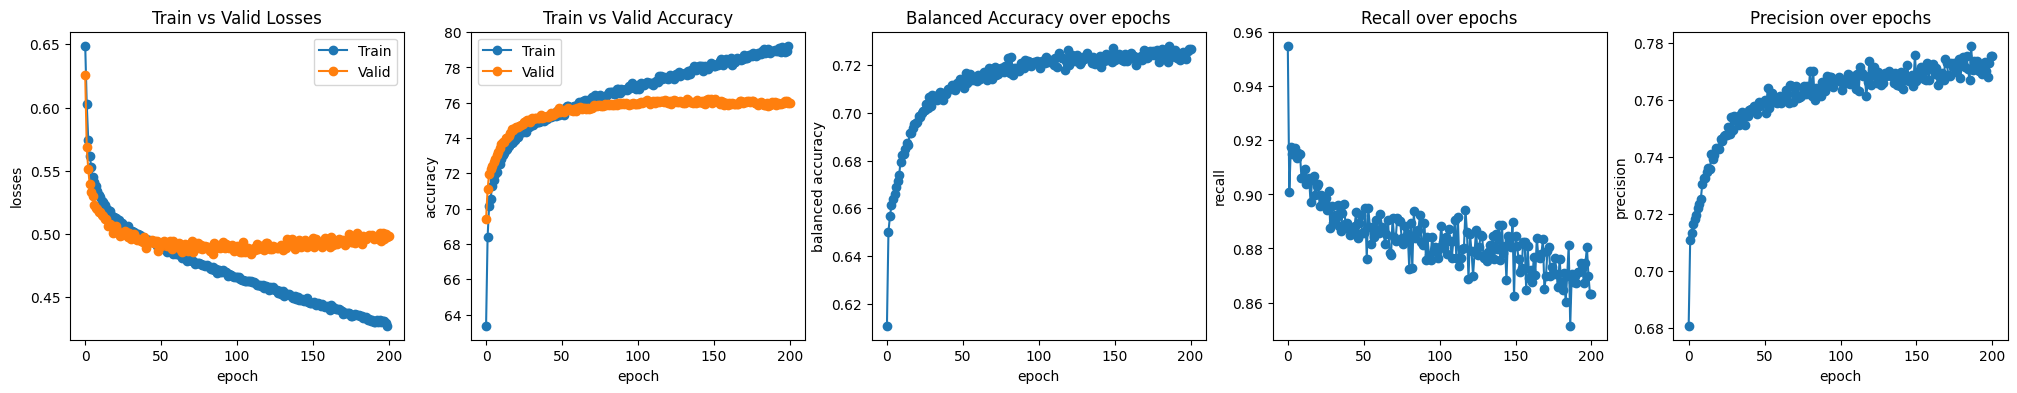

In [10]:
# plot the loss and accuracy and
metrics = {
    'train_losses': train_losses,
    'train_accu': train_accu,
    'eval_losses': eval_losses,
    'eval_accu': eval_accu,
    'balance_accuracy_list': balance_accuracy_list,
    'precision_list': precision_list,
    'recall_list': recall_list
}
plot_metrics(metrics, ['loss', 'accuracy', 'balance_accuracy', 'recall', 'precision'])

In [11]:
accuracy, precision, recall, balance_accuracy = test_model('models/FeedForwardNet/saved_model.pth', 'RCAST')

In [12]:
print(f'Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | Balance Accuracy: {balance_accuracy:.3f}')

Accuracy: 0.760 | Precision: 0.775 | Recall: 0.863 | Balance Accuracy: 0.727
